<a href="https://colab.research.google.com/github/jacobgreen4477/Construction-Equipment-Oil-Condition-Classification-AI-Competition/blob/main/ETRI_v1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy <br>

In our study, we used smartphones, smartwatches, sleep sensors, and self-recording apps to collect daily life logs and sleep health records of study participants in 2024.The data collection procedures and methods followed a similar approach to those used in previous studies. Here, we pu﻿blicly provide the following 12 data items, which comprise a total of 700 days' worth of lifelog data, strictly for non-commercial and academic research purposes only.
- mACStatus: Indicates whether the smartphone is currently being charged.
- mActivity: Value calculated by the Google Activity Recognition API.
- mAmbience: Ambient sound identification labels and their respective probabilities.
- mBle: Bluetooth devices around individual subject.
- mGps: Multiple GPS coordinates measured within a single minute using the smartphone.
- mLight: Ambient light measured by the smartphone.
- mScreenStatus: Indicates whether the smartphone screen is in use.
- mUsageStats: Indicates which apps were used on the smartphone and for how long.
- mWifi: Wifi devices around individual subject.
- wHr: Heart rate readings recorded by the smartwatch.
- wLight: Ambient light measured by the smartwatch.
- wPedo: Step data recorded by the smartwatch.

For the purpose of training a learning model to predict sleep health, fatigue, and stress, the following six metrics were derived from sleep sensor data and self-reported survey records. Each metric consists of values categorized into either two levels (0, 1) or three levels (0, 1, 2), depending on the specific metric. The detailed classification criteria for each metric's levels will be provided in a separate document.
- Q1: Overall sleep quality as perceived by a subject immediately after waking up.
- Q2: Physical fatigue of a subject just before sleep.
- Q3: Stress level experienced by a subject just before sleep.
- S1: Adherence to sleep guidelines for total sleep time (TST).
- S2: Adherence to sleep guidelines for sleep efficiency (SE).
- S3: Adherence to sleep guidelines for sleep onset latency (SOL, or SL).

In [202]:
! pip install haversine
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from tqdm.auto import tqdm
from collections import Counter
from scipy.stats import entropy
from haversine import haversine  # 설치 필요: pip install haversine

warnings.filterwarnings('ignore')

In [203]:
import re
import ast

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
# pandas 옵션
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

In [206]:
def plot_rssi_by_subject_topN(df, TOPN):
    """
    subject_id별로 가장 자주 등장한 상위 N개 BSSID에 대해 RSSI 시계열 시각화
    - RSSI -70 이하 신호는 제외 (None 처리)
    - 선 투명도 50%
    """
    grouped = df.groupby("subject_id")

    for subject, group in grouped:
        timestamps = []
        bssid_counter = Counter()

        # 모든 BSSID 등장 횟수 카운트
        for _, row in group.iterrows():
            bssid_counter.update(row['bssid'])

        # TOP N BSSID 추출
        target_bssids = [b for b, _ in bssid_counter.most_common(TOPN)]
        time_series = {bssid: [] for bssid in target_bssids}

        # 시간별 RSSI 수집 (단, -60 이하는 제거)
        for _, row in group.iterrows():
            timestamps.append(pd.to_datetime(row['timestamp']))
            row_bssid = row['bssid']
            row_rssi = row['rssi']

            for bssid in target_bssids:
                if bssid in row_bssid:
                    idx = row_bssid.index(bssid)
                    rssi_value = row_rssi[idx]
                    if rssi_value > -60:
                        time_series[bssid].append(rssi_value)
                    else:
                        time_series[bssid].append(None)  # 약한 신호는 제외
                else:
                    time_series[bssid].append(None)  # 없는 BSSID

        # 시각화
        plt.figure(figsize=(16, 7))
        for bssid in target_bssids:
            plt.plot(timestamps, time_series[bssid], label=bssid, marker='o', alpha=0.5)

        plt.title(f"[{subject}] 시간별 RSSI 변화 (TOP {TOPN}, -60 이상만)", fontsize=14)
        plt.xlabel("시간")
        plt.ylabel("RSSI (dBm)")
        plt.xticks(rotation=45)
        plt.legend(title="BSSID", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [207]:
def filter_strong_rssi(df, threshold=-60):
    """
    각 row의 RSSI 값 중 threshold 이하인 항목 제거

    Parameters:
    - df: DataFrame with 'bssid' and 'rssi' as lists
    - threshold: int, RSSI 값 기준 (기본: -60)

    Returns:
    - 필터링된 DataFrame (in-place 수정 아님)
    """
    filtered_df = df.copy()

    def filter_row(row):
        bssids = row['bssid']
        rssis = row['rssi']
        # RSSI > threshold 조건 만족하는 항목만 추출
        filtered = [(b, r) for b, r in zip(bssids, rssis) if r > threshold]
        if filtered:
            new_bssids, new_rssis = zip(*filtered)
            return pd.Series({'bssid': list(new_bssids), 'rssi': list(new_rssis)})
        else:
            return pd.Series({'bssid': [], 'rssi': []})

    filtered_df[['bssid', 'rssi']] = filtered_df.apply(filter_row, axis=1)
    return filtered_df

In [208]:
def daily_wifi_features_by_user(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    features = []

    # subject_id + lifelog_date 기준 그룹화
    grouped = df.groupby(['subject_id', 'lifelog_date'])

    for (subject_id, date), group in grouped:
        scan_count = len(group)
        bssid_flat = sum(group['bssid'], [])  # flatten
        rssi_flat = sum(group['rssi'], [])    # flatten

        unique_bssid_count = len(set(bssid_flat))
        avg_rssi = sum(rssi_flat) / len(rssi_flat) if rssi_flat else None
        max_rssi = max(rssi_flat) if rssi_flat else None
        min_rssi = min(rssi_flat) if rssi_flat else None
        strong_rssi_ratio = sum(1 for r in rssi_flat if r > -60) / len(rssi_flat) if rssi_flat else 0
        empty_scan_count = sum(1 for b in group['bssid'] if len(b) == 0)

        # 가장 많이 탐지된 BSSID
        bssid_counter = Counter(bssid_flat)
        top_bssid, top_bssid_count = bssid_counter.most_common(1)[0] if bssid_counter else (None, 0)

        first_time = group['timestamp'].min()
        last_time = group['timestamp'].max()
        hour_span = (last_time - first_time).total_seconds() / 60  # 분 단위

        features.append({
            'subject_id': subject_id,
            'lifelog_date': date,
            'scan_count': scan_count,
            'unique_bssid_count': unique_bssid_count,
            'avg_rssi': avg_rssi,
            'max_rssi': max_rssi,
            'min_rssi': min_rssi,
            'strong_signal_ratio': strong_rssi_ratio,
            'empty_scan_count': empty_scan_count,
            'top_bssid': top_bssid,
            'top_bssid_count': top_bssid_count,
            #'time_first_seen': first_time,
            # 'time_last_seen': last_time,
            'hour_span_minutes': hour_span
        })

    return pd.DataFrame(features)

### 데이터 읽기

In [209]:
path = '/content/drive/MyDrive/data/ch2025_data_items/'

# 1
ch2025_mACStatus = pd.read_parquet(path+'ch2025_mACStatus.parquet')
ch2025_mActivity = pd.read_parquet(path+'ch2025_mActivity.parquet')
ch2025_mAmbience = pd.read_parquet(path+'ch2025_mAmbience.parquet')
ch2025_mBle = pd.read_parquet(path+'ch2025_mBle.parquet')
ch2025_mGps = pd.read_parquet(path+'ch2025_mGps.parquet')
ch2025_mLight = pd.read_parquet(path+'ch2025_mLight.parquet')
ch2025_mScreenStatus = pd.read_parquet(path+'ch2025_mScreenStatus.parquet')
ch2025_mUsageStats = pd.read_parquet(path+'ch2025_mUsageStats.parquet')
ch2025_mWifi = pd.read_parquet(path+'ch2025_mWifi.parquet')
ch2025_wHr = pd.read_parquet(path+'ch2025_wHr.parquet')
ch2025_wLight = pd.read_parquet(path+'ch2025_wLight.parquet')
ch2025_wPedo = pd.read_parquet(path+'ch2025_wPedo.parquet')

# 2
train = pd.read_csv('/content/drive/MyDrive/data/ch2025_metrics_train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/ch2025_submission_sample.csv')

### ✅ mACStatus 핸드폰 충전상태
- Indicates whether the smartphone is currently being charged.
- m_charging : 0/1 상태
- 핸드폰이 오랫 동안 충전했다는 의미?
 - 한 자리에 장시간 머물러 있었다.
 - 핸드폰을 장시간 사용하지 않았다.  

In [11]:
ch2025_mACStatus['lifelog_date'] = ch2025_mACStatus['timestamp'].astype(str).str[:10]
ch2025_mACStatus.head(1)

,subject_id,timestamp,m_charging,lifelog_date
0,id01,2024-06-26 12:03:00,0,2024-06-26


In [34]:
def process_mACStatus(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(['subject_id', 'timestamp'])

    results = []

    for (subj, lifelog_date), group in df.groupby(['subject_id', 'lifelog_date']):
        status = group['m_charging'].values  # 0/1 상태
        times = group['timestamp'].values

        ratio_charging = status.mean()
        sum_charging = status.sum()

        # 상태 전이 횟수
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        lengths = []
        current_len = 0
        for val in status:
            if val == 1:
                current_len += 1
            elif current_len > 0:
                lengths.append(current_len)
                current_len = 0
        if current_len > 0:
            lengths.append(current_len)

        avg_charging_duration = np.mean(lengths) if lengths else 0
        max_charging_duration = np.max(lengths) if lengths else 0

        results.append({
            'subject_id': subj,
            'lifelog_date': lifelog_date,
            'charging_ratio': ratio_charging,
            'charging_sum': sum_charging,
            'charging_transitions': transitions,
            'avg_charging_duration': avg_charging_duration,
            'max_charging_duration': max_charging_duration,
        })

    return pd.DataFrame(results)

ch2025_mACStatus2 = process_mACStatus(ch2025_mACStatus)

# check
print(f'# ch2025_mACStatus2 shape: {ch2025_mACStatus2.shape}')
ch2025_mACStatus2.head()

# ch2025_mACStatus2 shape: (700, 7)


,subject_id,lifelog_date,charging_ratio,charging_sum,charging_transitions,avg_charging_duration,max_charging_duration
0,id01,2024-06-26,0.2159,147,22,13.3636,41
1,id01,2024-06-27,0.1586,222,32,13.8750,65
2,id01,2024-06-28,0.1803,256,29,17.0667,76
3,id01,2024-06-29,0.2866,384,3,192.0000,328
4,id01,2024-06-30,0.1443,202,8,50.5000,91


### ✅ mActivity 추정행동
- Value calculated by the Google Activity Recognition API.
 - 0 : IN_VEHICLE
 - 1 : ON_BICYCLE
 - 2 : ON_FOOT
 - 3 : STILL (not moving)
 - 8 : RUNNING
 - 3 : TILTING (This often occurs when a device is picked up from a desk or a user who is sitting stands up.)
 - 4 : UNKNOWN
 - 7 : WALKING

- 근무시간   : 오전 7시부터 오후 6시까지
- 근무외시간 : 오후6시부터 12시까지

In [14]:
ch2025_mActivity['lifelog_date'] = ch2025_mActivity['timestamp'].astype(str).str[:10]
ch2025_mActivity.head(1)

,subject_id,timestamp,m_activity,lifelog_date
0,id01,2024-06-26 12:03:00,4,2024-06-26


In [31]:
def process_mActivity_by_timezones(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    def summarize(group_df, prefix=''):
        summary = []
        for (subj, date), group in group_df.groupby(['subject_id', 'lifelog_date']):
            counts = group['m_activity'].value_counts(normalize=True)
            counts2 = group['m_activity'].value_counts()
            row = {'subject_id': subj, 'lifelog_date': date}

            for i in range(9):
                row[f'{prefix}activity_{i}_ratio'] = counts.get(i, 0)
                row[f'{prefix}activity_{i}_count'] = counts2.get(i, 0)

            row[f'{prefix}dominant_activity'] = group['m_activity'].mode()[0] if not group['m_activity'].mode().empty else None
            row[f'{prefix}num_unique_activities'] = group['m_activity'].nunique()

            summary.append(row)
        return pd.DataFrame(summary)

    # 전체 데이터 요약 (prefix 없음)
    total_summary = summarize(df)

    # 근무시간 (07:00 ~ 18:00)
    worktime_df = df[(df['hour'] >= 7) & (df['hour'] < 18)]
    worktime_summary = summarize(worktime_df, prefix='worktime_')

    # 근무외시간 (18:00 ~ 24:00)
    afterwork_df = df[(df['hour'] >= 18) & (df['hour'] < 24)]
    afterwork_summary = summarize(afterwork_df, prefix='afterwork_')

    # 취침시간 (00:00 ~ 07:00)
    sleeptime_df = df[(df['hour'] >= 0) & (df['hour'] < 7)]
    sleeptime_summary = summarize(sleeptime_df, prefix='sleeptime_')

    # subject_id와 lifelog_date 기준으로 모두 합치기
    result = total_summary.copy()
    result = pd.merge(result, worktime_summary, on=['subject_id', 'lifelog_date'], how='left')
    result = pd.merge(result, afterwork_summary, on=['subject_id', 'lifelog_date'], how='left')
    result = pd.merge(result, sleeptime_summary, on=['subject_id', 'lifelog_date'], how='left')

    # 컬럼 정렬
    cols = ['subject_id', 'lifelog_date'] + [col for col in result.columns if col not in ['subject_id', 'lifelog_date']]
    result = result[cols]

    # 결측 처리
    result = result.fillna(0)

    return result

ch2025_mActivity2 = process_mActivity_by_timezones(ch2025_mActivity)

# check
print(f'# ch2025_mActivity2 shape: {ch2025_mActivity2.shape}')
ch2025_mActivity2.head()

# ch2025_mActivity2 shape: (700, 82)


,subject_id,lifelog_date,activity_0_ratio,activity_0_count,activity_1_ratio,activity_1_count,activity_2_ratio,activity_2_count,activity_3_ratio,activity_3_count,activity_4_ratio,activity_4_count,activity_5_ratio,activity_5_count,activity_6_ratio,activity_6_count,activity_7_ratio,activity_7_count,activity_8_ratio,activity_8_count,dominant_activity,num_unique_activities,worktime_activity_0_ratio,worktime_activity_0_count,worktime_activity_1_ratio,worktime_activity_1_count,worktime_activity_2_ratio,worktime_activity_2_count,worktime_activity_3_ratio,worktime_activity_3_count,worktime_activity_4_ratio,worktime_activity_4_count,worktime_activity_5_ratio,worktime_activity_5_count,worktime_activity_6_ratio,worktime_activity_6_count,worktime_activity_7_ratio,worktime_activity_7_count,worktime_activity_8_ratio,worktime_activity_8_count,worktime_dominant_activity,worktime_num_unique_activities,afterwork_activity_0_ratio,afterwork_activity_0_count,afterwork_activity_1_ratio,afterwork_activity_1_count,afterwork_activity_2_ratio,afterwork_activity_2_count,afterwork_activity_3_ratio,afterwork_activity_3_count,afterwork_activity_4_ratio,afterwork_activity_4_count,afterwork_activity_5_ratio,afterwork_activity_5_count,afterwork_activity_6_ratio,afterwork_activity_6_count,afterwork_activity_7_ratio,afterwork_activity_7_count,afterwork_activity_8_ratio,afterwork_activity_8_count,afterwork_dominant_activity,afterwork_num_unique_activities,sleeptime_activity_0_ratio,sleeptime_activity_0_count,sleeptime_activity_1_ratio,sleeptime_activity_1_count,sleeptime_activity_2_ratio,sleeptime_activity_2_count,sleeptime_activity_3_ratio,sleeptime_activity_3_count,sleeptime_activity_4_ratio,sleeptime_activity_4_count,sleeptime_activity_5_ratio,sleeptime_activity_5_count,sleeptime_activity_6_ratio,sleeptime_activity_6_count,sleeptime_activity_7_ratio,sleeptime_activity_7_count,sleeptime_activity_8_ratio,sleeptime_activity_8_count,sleeptime_dominant_activity,sleeptime_num_unique_activities
0,id01,2024-06-26,0.1252,89,0.0014,1,0,0,0.6723,478,0.1575,112,0,0,0,0,0.0436,31,0.0000,0,3,5,0.0700,25.0000,0.0028,1.0000,0.0000,0.0000,0.8768,313.0000,0.0028,1.0000,0.0000,0.0000,0.0000,0.0000,0.0476,17.0000,0.0000,0.0000,3.0000,5.0000,0.1808,64.0000,0.0000,0.0000,0.0000,0.0000,0.4661,165.0000,0.3136,111.0000,0.0000,0.0000,0.0000,0.0000,0.0395,14.0000,0.0000,0.0000,3.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,id01,2024-06-27,0.1465,211,0.0000,0,0,0,0.6111,880,0.2208,318,0,0,0,0,0.0215,31,0.0000,0,3,4,0.1030,68.0000,0.0000,0.0000,0.0000,0.0000,0.8712,575.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0258,17.0000,0.0000,0.0000,3.0000,3.0000,0.3222,116.0000,0.0000,0.0000,0.0000,0.0000,0.6528,235.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0250,9.0000,0.0000,0.0000,3.0000,3.0000,0.0643,27.0000,0.0000,0.0000,0.0000,0.0000,0.1667,70.0000,0.7571,318.0000,0.0000,0.0000,0.0000,0.0000,0.0119,5.0000,0.0000,0.0000,4.0000,4.0000
2,id01,2024-06-28,0.1118,161,0.0007,1,0,0,0.8618,1241,0.0007,1,0,0,0,0,0.0250,36,0.0000,0,3,5,0.1848,122.0000,0.0015,1.0000,0.0000,0.0000,0.7636,504.0000,0.0015,1.0000,0.0000,0.0000,0.0000,0.0000,0.0485,32.0000,0.0000,0.0000,3.0000,5.0000,0.0278,10.0000,0.0000,0.0000,0.0000,0.0000,0.9722,350.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,2.0000,0.0690,29.0000,0.0000,0.0000,0.0000,0.0000,0.9214,387.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0095,4.0000,0.0000,0.0000,3.0000,3.0000
3,id01,2024-06-29,0.0660,95,0.0000,0,0,0,0.9167,1320,0.0000,0,0,0,0,0,0.0174,25,0.0000,0,3,3,0.1242,82.0000,0.0000,0.0000,0.0000,0.0000,0.8424,556.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0333,22.0000,0.0000,0.0000,3.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,360.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,1.0000,0.0310,13.0000,0.0000,0.0000,0.0000,0.0000,0.9619,404.00

### ✅ mAmbience 추정주변소리
- Ambient sound identification labels and their respective probabilities.
- 무슨 소리가 난게 중요할까?
- 새벽에 무슨 소리던지 소리가 난게 중요한 걸까?
- 여러 가지 소리 중에 노이즈도 포함되어 있을까?

In [40]:
def extract_labels_and_probs(row):
    items = row['m_ambience']
    labels = [item[0] for item in items]
    probs = [item[1] for item in items]
    return pd.Series({'labels': labels, 'prob': probs})

ch2025_mAmbience[['labels', 'prob']]  = ch2025_mAmbience.apply(extract_labels_and_probs, axis=1)
ch2025_mAmbience['lifelog_date'] = ch2025_mAmbience['timestamp'].astype(str).str[:10]
ch2025_mAmbience = ch2025_mAmbience.drop(columns=['m_ambience'])
ch2025_mAmbience.head(1)

,subject_id,timestamp,labels,prob,lifelog_date
0,id01,2024-06-26 13:00:10,"[Music, Vehicle, Motor vehicle (road), Outside, urban or manmade, Outside, rural or natural, Car, Speech, Inside, large room or hall, Truck, Sound effect]","[0.30902618, 0.081680894, 0.04035286, 0.037144363, 0.032663062, 0.03199804, 0.029806137, 0.01684492, 0.016206821, 0.01591479]",2024-06-26


In [141]:
def process_mAmbience(df, top_n=3, special_labels=None):
    df = df.copy()

    # 시간 파생변수
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['weekday'] = df['timestamp'].dt.weekday
    df['is_weekend'] = df['weekday'] >= 5

    def map_time_period(row):
        if 0 <= row['hour'] < 7:
            return 'sleeptime'
        elif 7 <= row['hour'] < 18:
            return 'worktime'
        else:
            return 'afterwork'

    df['time_period'] = df.apply(map_time_period, axis=1)

    # 타임스탬프 차이(초단위)
    df = df.sort_values(['subject_id', 'timestamp'])
    df['duration_sec'] = df.groupby(['subject_id'])['timestamp'].diff().dt.total_seconds()
    df['duration_sec'] = df['duration_sec'].fillna(0)

    def process_group(group):
        result = {}

        time_period = group['time_period'].iloc[0]  # 그룹별 time_period 가져오기

        labels = group['labels'].tolist()
        probs = group['prob'].tolist()
        durations = group['duration_sec'].tolist()

        flat_labels = [label for labels_list in labels for label in labels_list]
        flat_probs = [float(prob) for probs_list in probs for prob in probs_list]
        repeated_durations = [dur for labels_list, dur in zip(labels, durations) for _ in labels_list]

        if not flat_labels or not flat_probs:
            return pd.Series()

        flat_probs = np.array(flat_probs)

        # prefix 설정
        prefix = f'{time_period}_'

        result[prefix + 'max_label'] = flat_labels[np.argmax(flat_probs)]
        result[prefix + 'max_prob'] = np.max(flat_probs)
        result[prefix + 'entropy'] = entropy(flat_probs, base=2)
        result[prefix + 'label_count'] = len(flat_labels)

        # 정규식
        vehicle_pattern = re.compile(r'car|vehicle|truck|bus|motorcycle|bicycle|boat|ship|train|subway|aircraft|helicopter|engine', re.IGNORECASE)
        environment_pattern = re.compile(r'outside|inside|environment|ocean|rain|waterfall|wind|fire|waves|rustling|earthquake|explosion|thunder|smoke', re.IGNORECASE)
        human_pattern = re.compile(r'speech|baby|child|laughter|crying|shout|screaming|groan|cough|hubbub|snoring|whimper|talking|singing|giggle|chatter|babbling', re.IGNORECASE)
        music_pattern = re.compile(r'music|song|singing|choir|instrument|guitar|piano|violin|vocal|jazz|hip hop|pop|rock|opera|blues|folk|electronic|dubstep|reggae|house|metal|disco|dance|flamenco|trance|techno|saxophone|synthesizer|harp|accordion|clarinet|flute|drum|tabla|tambourine|maraca|steelpan|xylophone|orchestra|band', re.IGNORECASE)

        # 분류
        vehicle_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if vehicle_pattern.search(label)]
        environment_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if environment_pattern.search(label)]
        human_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if human_pattern.search(label)]
        music_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if music_pattern.search(label)]

        # has (존재 여부)
        result[prefix + 'has_vehicle_related'] = int(len(vehicle_related) > 0)
        result[prefix + 'has_environment_related'] = int(len(environment_related) > 0)
        result[prefix + 'has_human_related'] = int(len(human_related) > 0)
        result[prefix + 'has_music_related'] = int(len(music_related) > 0)

        # sum (개수)
        result[prefix + 'sum_vehicle_related'] = len(vehicle_related)
        result[prefix + 'sum_environment_related'] = len(environment_related)
        result[prefix + 'sum_human_related'] = len(human_related)

        return pd.Series(result)

    features = df.groupby(['subject_id', 'lifelog_date', 'time_period']).apply(process_group).reset_index()
    features = features.pivot(index=['subject_id', 'lifelog_date'], columns='level_3', values=0).reset_index()

    return features

In [142]:
ch2025_mAmbience2 = process_mAmbience(ch2025_mAmbience)

# check
print(f'# ch2025_mAmbience2 shape: {ch2025_mAmbience2.shape}')
ch2025_mAmbience2.head()

# ch2025_mAmbience2 shape: (700, 35)


level_3,subject_id,lifelog_date,afterwork_entropy,afterwork_has_environment_related,afterwork_has_human_related,afterwork_has_music_related,afterwork_has_vehicle_related,afterwork_label_count,afterwork_max_label,afterwork_max_prob,afterwork_sum_environment_related,afterwork_sum_human_related,afterwork_sum_vehicle_related,sleeptime_entropy,sleeptime_has_environment_related,sleeptime_has_human_related,sleeptime_has_music_related,sleeptime_has_vehicle_related,sleeptime_label_count,sleeptime_max_label,sleeptime_max_prob,sleeptime_sum_environment_related,sleeptime_sum_human_related,sleeptime_sum_vehicle_related,worktime_entropy,worktime_has_environment_related,worktime_has_human_related,worktime_has_music_related,worktime_has_vehicle_related,worktime_label_count,worktime_max_label,worktime_max_prob,worktime_sum_environment_related,worktime_sum_human_related,worktime_sum_vehicle_related
0,id01,2024-06-26,9.2578,1,1,1,1,1540,Silence,1.0000,258,244,333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.1810,1,1,1,1,1500,Silence,1.0000,415,135,270
1,id01,2024-06-27,7.4919,1,1,1,0,1800,Silence,1.0000,180,900,0,7.7287,1,1,1,1,2100,Silence,1.0000,211,1045,6,8.3663,1,1,1,0,3300,Silence,1.0000,330,1650,0
2,id01,2024-06-28,7.4933,1,1,1,0,1800,Silence,1.0000,183,898,0,7.7476,1,1,1,1,2100,Silence,1.0000,214,1041,6,8.3219,1,1,1,0,3200,Silence,1.0000,320,1600,0
3,id01,2024-06-29,7.4919,1,1,1,0,1800,Silence,1.0000,180,900,0,7.7142,1,1,1,0,2100,Silence,1.0000,210,1050,0,8.3812,1,1,1,0,3300,Silence,1.0000,330,1645,0
4,id01,2024-06-30,7.5039,1,1,1,1,1800,Silence,1.0000,184,895,1,7.7142,1,1,1,0,2100,Silence,1.0000,210,1050,0,8.3663,1,1,1,0,3300,Silence,1.0000,330,1650,0


### ✅ mBle 블루투스
- Bluetooth devices around individual subject.
 - 7936 : Wearable, Headset, AV Device
 - 1796 : Peripheral (입력장치) 계열
 - 0 : 정보 없음 또는 알 수 없음(Unknown)
 - 1084 : Audio/Video (스피커, 헤드셋, 이어폰, TV 등)
 - 524 : Phone (휴대폰, 스마트폰)
 - 1060 : Headphones
 - 284 : commputer (PC, 노트북, PDA)

In [157]:
def extract_mble_info(row):
    m_data = row['m_ble']
    address = [item['address'] for item in m_data]
    device_class = [item['device_class'] for item in m_data]
    rssi = [item['rssi'] for item in m_data]
    return pd.Series({'address': address, 'device_class': device_class, 'rssi': rssi})

ch2025_mBle[['address','device_class','rssi']] = ch2025_mBle.apply(extract_mble_info, axis=1)
ch2025_mBle['lifelog_date'] = ch2025_mBle['timestamp'].astype(str).str[:10]
ch2025_mBle.head(1)

,subject_id,timestamp,m_ble,address,device_class,rssi,lifelog_date
0,id01,2024-06-26 12:13:00,"[{'address': '00:15:7C:11:80:8D', 'device_class': '0', 'rssi': -82}, {'address': '01:B1:D2:20:9E:3A', 'device_class': '0', 'rssi': -61}, {'address': '04:33:1F:D9:C1:50', 'device_class': '0', 'rssi': -86}, {'address': '06:5C:2D:BC:39:BE', 'device_class': '0', 'rssi': -75}, {'address': '09:42:21:0D:AD:DF', 'device_class': '0', 'rssi': -70}, {'address': '0B:66:0D:D5:9C:4A', 'device_class': '0', 'rssi': -89}, {'address': '10:B5:88:E7:85:69', 'device_class': '0', 'rssi': -89}, {'address': '13:F0:CA:3B:DB:EF', 'device_class': '0', 'rssi': -77}, {'address': '1A:23:C0:8F:43:4D', 'device_class': '0', 'rssi': -66}, {'address': '24:11:53:BB:62:89', 'device_class': '1796', 'rssi': -37}, {'address': '24:2D:F0:EE:1E:D0', 'device_class': '0', 'rssi': -85}, {'address': '26:0C:48:28:15:77', 'device_class': '0', 'rssi': -63}, {'address': '27:C1:C0:8B:82:C9', 'device_class': '0', 'rssi': -88}, {'address': '28:9C:11:73:39:05', 'device_class': '0', 'rssi': -30}, {'address': '34:40:DE:35:F8:65', 'device_class': '0', 'rssi': -93}, {'address': '35:0A:59:BF:75:F5', 'device_class': '0', 'rssi': -72}, {'address': '41:A6:C4:20:E3:2C', 'device_class': '7936', 'rssi': -83}, {'address': '42:6B:51:95:1B:D4', 'device_class': '0', 'rssi': -77}, {'address': '44:B2:0B:78:04:0F', 'device_class': '0', 'rssi': -69}, {'address': '45:37:48:E2:7F:CC', 'device_class': '0', 'rssi': -87}, {'address': '4E:1B:C2:DF:C5:87', 'device_class': '0', 'rssi': -76}, {'address': '4E:9F:1B:A9:56:5D', 'device_class': '0', 'rssi': -66}, {'address': '50:63:B0:82:07:00', 'device_class': '0', 'rssi': -86}, {'address': '53:13:6C:4F:04:D2', 'device_class': '0', 'rssi': -69}, {'address': '54:15:89:95:27:44', 'device_class': '7936', 'rssi': -71}, {'address': '56:0E:2E:B0:D4:11', 'device_class': '0', 'rssi': -61}, {'address': '5A:7A:2E:42:03:B1', 'device_class': '0', 'rssi': -82}, {'address': '5A:9D:3E:AB:38:C6', 'device_class': '0', 'rssi': -83}, {'address': '5E:A6:8E:B8:74:74', 'device_class': '0', 'rssi': -84}, {'address': '5F:BC:08:0F:C1:6A', 'device_class': '0', 'rssi': -87}, {'address': '62:E1:9D:41:F4:AE', 'device_class': '0', 'rssi': -73}, {'address': '67:23:FE:88:69:A8', 'device_class': '0', 'rssi': -88}, {'address': '68:EC:C5:0C:D1:C1', 'device_class': '0', 'rssi': -78}, {'address': '6B:28:DA:C0:1B:29', 'device_class': '0', 'rssi': -75}, {'address': '6F:0B:91:00:33:19', 'device_class': '0', 'rssi': -80}, {'address': '70:7A:4B:82:44:90', 'device_class': '0', 'rssi': -88}, {'address': '7B:62:D4:5B:59:D3', 'device_class': '0', 'rssi': -74}, {'address': '7B:BE:A4:9D:FD:11', 'device_class': '0', 'rssi': -72}, {'address': '7F:FD:C4:00:77:7D', 'device_class': '0', 'rssi': -52}, {'address': 'C4:F0:92:C8:F1:8D', 'device_class': '7936', 'rssi': -87}, {'address': 'C7:3F:2C:7B:86:66', 'device_class': '7936', 'rssi': -89}]","[00:15:7C:11:80:8D, 01:B1:D2:20:9E:3A, 04:33:1F:D9:C1:50, 06:5C:2D:BC:39:BE, 09:42:21:0D:AD:DF, 0B:66:0D:D5:9C:4A, 10:B5:88:E7:85:69, 13:F0:CA:3B:DB:EF, 1A:23:C0:8F:43:4D, 24:11:53:BB:62:89, 24:2D:F0:EE:1E:D0, 26:0C:48:28:15:77, 27:C1:C0:8B:82:C9, 28:9C:11:73:39:05, 34:40:DE:35:F8:65, 35:0A:59:BF:75:F5, 41:A6:C4:20:E3:2C, 42:6B:51:95:1B:D4, 44:B2:0B:78:04:0F, 45:37:48:E2:7F:CC, 4E:1B:C2:DF:C5:87, 4E:9F:1B:A9:56:5D, 50:63:B0:82:07:00, 53:13:6C:4F:04:D2, 54:15:89:95:27:44, 56:0E:2E:B0:D4:11, 5A:7A:2E:42:03:B1, 5A:9D:3E:AB:38:C6, 5E:A6:8E:B8:74:74, 5F:BC:08:0F:C1:6A, 62:E1:9D:41:F4:AE, 67:23:FE:88:69:A8, 68:EC:C5:0C:D1:C1, 6B:28:DA:C0:1B:29, 6F:0B:91:00:33:19, 70:7A:4B:82:44:90, 7B:62:D4:5B:59:D3, 7B:BE:A4:9D:FD:11, 7F:FD:C4:00:77:7D, C4:F0:92:C8:F1:8D, C7:3F:2C:7B:86:66]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1796, 0, 0, 0, 0, 0, 0, 7936, 0, 0, 0, 0, 0, 0, 0, 7936, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7936, 7936]","[-82, -61, -86, -75, -70, -89, -89, -77, -66, -37, -85, -63, -88, -30, -93, -72, -83, -77, -69, -87, -76, -66, -86, -69, -71, -61, -82, -83, -84, -87, -73, -88, -78, -75, -80, 

In [173]:
def process_mBle(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 시간대 분류
    def map_time_period(row):
        if 0 <= row['hour'] < 7:
            return 'sleeptime'
        elif 7 <= row['hour'] < 18:
            return 'worktime'
        else:
            return 'afterwork'

    df['time_period'] = df.apply(map_time_period, axis=1)

    features = []

    for idx, row in df.iterrows():
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble']

        rssi_list = []
        class_0_cnt = 0
        class_other_cnt = 0

        for device in entry:
            try:
                rssi = int(device['rssi'])
                rssi_list.append(rssi)

                device_class = str(device['device_class'])
                if device_class == '0':
                    class_0_cnt += 1
                else:
                    class_other_cnt += 1
            except:
                continue  # malformed record

        feature = {
            'subject_id': row['subject_id'],
            'lifelog_date': row['lifelog_date'],
            'time_period': row['time_period'],
            'device_class_0_cnt': class_0_cnt,
            'device_class_others_cnt': class_other_cnt,
            'device_count': len(rssi_list),
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan,
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan,
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan,
        }
        features.append(feature)

    return pd.DataFrame(features)

def summarize_mBle_daily(df):

    # row 단위 BLE feature 추출
    df = process_mBle(df)

    # 하루 + 시간대별로 groupby
    grouped = df.groupby(['subject_id', 'lifelog_date', 'time_period']).agg({
        'device_class_0_cnt': 'sum',
        'device_class_others_cnt': 'sum',
        'rssi_mean': 'mean',
        'rssi_min': 'min',
        'rssi_max': 'max',
    }).reset_index()

    # 총합 구해서 비율 계산
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan)
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan)

    # 필요 없는 cnt 컬럼 제거
    grouped.drop(columns=[
        'device_class_0_cnt',
        'device_class_others_cnt'
    ], inplace=True)

    # pivot해서 time_period별로 펼치기
    final = grouped.pivot(index=['subject_id', 'lifelog_date'], columns='time_period')
    final.columns = ['_'.join(col).strip() for col in final.columns.values]
    final = final.reset_index()

    return final

In [174]:
ch2025_mBl2 = summarize_mBle_daily(ch2025_mBle)

# check
print(f'# ch2025_mBl2 shape: {ch2025_mBl2.shape}')
ch2025_mBl2.head()

# ch2025_mBl2 shape: (651, 17)


,subject_id,lifelog_date,rssi_mean_afterwork,rssi_mean_sleeptime,rssi_mean_worktime,rssi_min_afterwork,rssi_min_sleeptime,rssi_min_worktime,rssi_max_afterwork,rssi_max_sleeptime,rssi_max_worktime,device_class_0_ratio_afterwork,device_class_0_ratio_sleeptime,device_class_0_ratio_worktime,device_class_others_ratio_afterwork,device_class_others_ratio_sleeptime,device_class_others_ratio_worktime
0,id01,2024-06-26,-76.2155,NaN,-75.0522,-92.0000,NaN,-94.0000,-43.0000,NaN,-27.0000,0.9237,NaN,0.9421,0.0763,NaN,0.0579
1,id01,2024-06-27,-71.3198,-75.4567,-74.7020,-94.0000,-89.0000,-93.0000,-34.0000,-55.0000,-46.0000,0.8482,0.7826,0.9457,0.1518,0.2174,0.0543
2,id01,2024-06-28,-76.6775,-74.1250,-77.2920,-94.0000,-91.0000,-92.0000,-45.0000,-60.0000,-39.0000,0.6491,0.6250,0.9580,0.3509,0.3750,0.0420
3,id01,2024-06-29,-74.7198,-61.6667,-66.8632,-92.0000,-89.0000,-93.0000,-40.0000,-33.0000,-38.0000,0.8519,0.7000,0.7740,0.1481,0.3000,0.2260
4,id01,2024-06-30,-69.9323,-72.0000,-77.2568,-92.0000,-72.0000,-92.0000,-35.0000,-72.0000,-40.0000,0.6538,1.0000,0.9231,0.3462,0.0000,0.0769


### ✅ mGps, GPS 기반 핸드폰 위치
- Multiple GPS coordinates measured within a single minute using the smartphone.
- speed가 1보다 큰경우 정지 상태가 아니고 움직이고 있다고 판단
 - 0.5-2 : 걸어서 이동하는 경우  
 - 2-5 : 조깅
 - 5 이상 : 차를 타고 이동하는 경우

- speed가 0.5-2사이를 하루에 몇분동안 지속했는지?
- speed가 2-5사이를 하루에 몇분동안 지속했는지? (유산소 운동 시간)
- speed가 5이상을 하루에 몇분동안 지속했는지?  

In [210]:
def extract_gps_info(row):
    m_data = row['m_gps']
    altitude = [item['altitude'] for item in m_data]
    latitude = [item['latitude'] for item in m_data]
    longitude = [item['longitude'] for item in m_data]
    speed = [item['speed'] for item in m_data]
    return pd.Series({'altitude': altitude, 'latitude': latitude, 'longitude': longitude, 'speed': speed})

ch2025_mGps[['altitude','latitude','longitude','speed']] = ch2025_mGps.apply(extract_gps_info, axis=1)
ch2025_mGps['lifelog_date'] = ch2025_mGps['timestamp'].astype(str).str[:10]
ch2025_mGps = ch2025_mGps.drop(columns=['m_gps'])
ch2025_mGps.head(1)

,subject_id,timestamp,altitude,latitude,longitude,speed,lifelog_date
0,id01,2024-06-26 12:03:00,"[110.6, 110.8, 110.8, 110.7, 110.7, 110.8, 110.8, 110.8, 110.8, 110.8, 110.8]","[0.2077385, 0.2077759, 0.2077728, 0.20779, 0.2077914, 0.2077972, 0.2078002, 0.2077985, 0.207801, 0.207802, 0.2078011]","[0.170027, 0.1699851, 0.1699834, 0.1699686, 0.1699708, 0.1699657, 0.1699627, 0.1699631, 0.1699642, 0.1699639, 0.169963]","[0.0, 0.721, 0.0505, 0.6587, 0.0568, 0.1768, 0.0907, 0.0337, 0.0411, 0.0296, 0.0194]",2024-06-26


<Axes: >

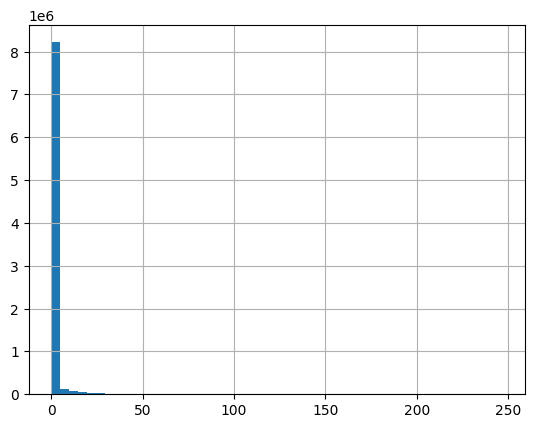

In [211]:
ch2025_mGps['speed'].explode().astype(float).hist(bins=50)

In [212]:
def calculate_daily_metrics(group):

    """그룹별 모든 메트릭을 계산하는 통합 함수"""
    # 리스트 데이터 추출 (예외 처리 추가)
    all_speeds = np.concatenate(group['speed'].tolist()) if 'speed' in group else []
    all_alts = np.concatenate(group['altitude'].tolist()) if 'altitude' in group else []
    all_lats = np.concatenate(group['latitude'].tolist()) if 'latitude' in group else []
    all_lons = np.concatenate(group['longitude'].tolist()) if 'longitude' in group else []

    # 기본 통계
    avg_speed = np.mean(all_speeds) if len(all_speeds) > 0 else 0
    max_alt = np.max(all_alts) if len(all_alts) > 0 else 0
    lat_std = np.std(all_lats) if len(all_lats) > 0 else 0

    # 이동 특성
    active_mins = group.shape[0]  # 관측치 수 = 활동 분
    movement_ratio = (all_speeds > 1.0).mean() if len(all_speeds) > 0 else 0

    # 공간 특성
    alt_change = all_alts[-1] - all_alts[0] if len(all_alts) > 0 else 0

    # 이동 거리 계산 (Haversine)
    total_dist = 0.0
    if len(all_lats) > 1:
        for i in range(len(all_lats)-1):
            coord1 = (all_lats[i], all_lons[i])
            coord2 = (all_lats[i+1], all_lons[i+1])
            total_dist += haversine(coord1, coord2, unit='m')  # 미터 단위


    return pd.Series({
        # 기본 통계
        'avg_speed': avg_speed,
        'max_speed': np.max(all_speeds) if len(all_speeds) > 0 else 0,
        'std_speed': np.std(all_speeds) if len(all_speeds) > 0 else 0,

        'max_altitude': max_alt,
        'lat_std': lat_std,

        # 이동 특성
        'active_minutes': active_mins,
        'movement_ratio': movement_ratio,

        # 공간 특성
        'altitude_change': alt_change,
        'total_distance(m)': total_dist,

    })

In [213]:
ch2025_mGps2 = ch2025_mGps.groupby(['subject_id', 'lifelog_date']).apply(calculate_daily_metrics).reset_index()

# check
print(f'# ch2025_mGps2 shape: {ch2025_mGps2.shape}')
ch2025_mGps2.head()

# ch2025_mGps2 shape: (660, 11)


,subject_id,lifelog_date,avg_speed,max_speed,std_speed,max_altitude,lat_std,active_minutes,movement_ratio,altitude_change,total_distance(m)
0,id01,2024-06-26,0.6605,28.2200,2.3350,136.9000,0.0106,707.0000,0.1034,-6.7000,29113.6162
1,id01,2024-06-27,1.0705,36.6356,3.2631,159.3000,0.0078,1439.0000,0.1401,0.0000,93470.9262
2,id01,2024-06-28,0.8132,49.5476,2.8764,133.8000,0.0087,1418.0000,0.1105,0.0000,68632.0779
3,id01,2024-06-29,0.5638,31.0703,2.0659,142.7000,0.0042,1440.0000,0.0865,0.6000,47104.6264
4,id01,2024-06-30,0.4235,33.8230,2.0439,133.8000,0.0022,1440.0000,0.0494,-0.3000,41159.5137


In [215]:
import pandas as pd
import numpy as np
import ast

def process_gps_features(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['week'] = df['timestamp'].dt.isocalendar().week

    features = []

    for idx, row in df.iterrows():
        speeds = ast.literal_eval(row['speed']) if isinstance(row['speed'], str) else row['speed']
        timestamps = pd.date_range(start=row['timestamp'], periods=len(speeds), freq='1S')  # 1초 간격 가정

        data = pd.DataFrame({
            'timestamp': timestamps,
            'speed': speeds
        })

        data['time_diff_min'] = 1 / 60  # 1초 간격이면 1/60 분

        # 활동 유형 지정
        def classify_activity(s):
            if 0.5 <= s < 2:
                return 'walking'
            elif 2 <= s < 5:
                return 'jogging'
            elif s >= 5:
                return 'vehicle'
            else:
                return 'stationary'

        data['activity'] = data['speed'].apply(classify_activity)

        walk_time = data[data['activity'] == 'walking']['time_diff_min'].sum()
        jog_time = data[data['activity'] == 'jogging']['time_diff_min'].sum()
        vehicle_time = data[data['activity'] == 'vehicle']['time_diff_min'].sum()

        speed_le_5 = data[data['speed'] <= 5]['speed']

        feature = {
            'subject_id': row['subject_id'],
            'lifelog_date': row['lifelog_date'],
            'walk_minutes': walk_time,
            'jog_minutes': jog_time,
            'vehicle_minutes': vehicle_time,
            'speed_le5_max': speed_le_5.max() if not speed_le_5.empty else np.nan,
            'speed_le5_mean': speed_le_5.mean() if not speed_le_5.empty else np.nan,
            'speed_le5_std': speed_le_5.std() if not speed_le_5.empty else np.nan,
            'first_movement_time': None,
            'last_nearzero_time': None
        }

        # 아침 최초 이동 시간 (speed > 0.5 이상 최초)
        moving = data[data['speed'] > 0.5]
        if not moving.empty:
            feature['first_movement_time'] = moving.iloc[0]['timestamp'].time()

        # 저녁 마지막 near zero (speed <= 0.1) 시간
        nearzero = data[data['speed'] <= 0.1]
        if not nearzero.empty:
            feature['last_nearzero_time'] = nearzero.iloc[-1]['timestamp'].time()

        features.append(feature)

    daily_features = pd.DataFrame(features)

    # 운동한 날: walk+조깅 시간 5분 이상이면 운동한 것으로 간주
    daily_features['exercise_flag'] = (daily_features['walk_minutes'] + daily_features['jog_minutes']) >= 5

    # 주별 운동 분석
    weekly = daily_features.groupby(['subject_id', pd.to_datetime(daily_features['lifelog_date']).dt.to_period('W')]).agg({
        'exercise_flag': 'sum',    # 일주일에 몇 번 운동했는지
        'walk_minutes': 'sum',
        'jog_minutes': 'sum'
    }).reset_index()

    weekly['weekly_exercise_minutes'] = weekly['walk_minutes'] + weekly['jog_minutes']

    weekly = weekly.rename(columns={
        'exercise_flag': 'weekly_exercise_days'
    })[['subject_id', 'lifelog_date', 'weekly_exercise_days', 'weekly_exercise_minutes']]

    # 최종 merge (daily + weekly)
    final = pd.merge(daily_features, weekly, on=['subject_id', 'lifelog_date'], how='left')

    return final

In [219]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm  # ← 추가

def process_gps_features_full_vector_with_progress(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['week'] = df['timestamp'].dt.isocalendar().week

    expanded_rows = []

    # tqdm 추가해서 progress 표시
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing GPS data"):
        speeds = ast.literal_eval(row['speed']) if isinstance(row['speed'], str) else row['speed']
        n = len(speeds)
        if n > 0:
            expanded_rows.append(pd.DataFrame({
                'subject_id': [row['subject_id']] * n,
                'lifelog_date': [row['lifelog_date']] * n,
                'timestamp': pd.date_range(start=row['timestamp'], periods=n, freq='1S'),
                'speed': speeds
            }))

    expanded_df = pd.concat(expanded_rows, ignore_index=True)

    # 2. 벡터화 연산
    speeds = expanded_df['speed'].values

    walk_mask = (0.5 <= speeds) & (speeds < 2)
    jog_mask = (2 <= speeds) & (speeds < 5)
    vehicle_mask = (speeds >= 5)
    le5_mask = (speeds <= 5)

    expanded_df['walk'] = walk_mask.astype(int)
    expanded_df['jog'] = jog_mask.astype(int)
    expanded_df['vehicle'] = vehicle_mask.astype(int)
    expanded_df['le5_speed'] = expanded_df['speed'].where(le5_mask)

    # 3. Groupby + Aggregation
    agg_funcs = {
        'walk': lambda x: x.sum() / 60,
        'jog': lambda x: x.sum() / 60,
        'vehicle': lambda x: x.sum() / 60,
        'le5_speed': ['max', 'mean', 'std'],
        'timestamp': ['min', 'max']
    }

    grouped = expanded_df.groupby(['subject_id', 'lifelog_date']).agg(agg_funcs)
    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()

    # 4. 이동 시작/정지 시간 추가
    grouped.rename(columns={
        'timestamp_min': 'first_movement_time',
        'timestamp_max': 'last_nearzero_time'
    }, inplace=True)

    grouped['first_movement_time'] = pd.to_datetime(grouped['first_movement_time']).dt.time
    grouped['last_nearzero_time'] = pd.to_datetime(grouped['last_nearzero_time']).dt.time

    # 5. 운동 flag
    grouped['exercise_flag'] = (grouped['walk_<lambda>'] + grouped['jog_<lambda>']) >= 5

    # 6. 주별 운동 집계
    grouped['week'] = pd.to_datetime(grouped['lifelog_date']).dt.to_period('W')
    weekly = grouped.groupby(['subject_id', 'week']).agg({
        'exercise_flag': 'sum',
        'walk_<lambda>': 'sum',
        'jog_<lambda>': 'sum'
    }).reset_index()

    weekly['weekly_exercise_minutes'] = weekly['walk_<lambda>'] + weekly['jog_<lambda>']
    weekly = weekly.rename(columns={
        'exercise_flag': 'weekly_exercise_days'
    })[['subject_id', 'week', 'weekly_exercise_days', 'weekly_exercise_minutes']]

    # 최종 merge
    final = pd.merge(grouped, weekly, on=['subject_id', 'week'], how='left')

    return final


In [ ]:
ch2025_mGps2 = process_gps_features_full_vector_with_progress(ch2025_mGps)

ch2025_mGps2.head()

Processing GPS data:  72%|███████▏  | 576039/800611 [08:38<8:23:35,  7.43it/s]

In [1]:
ch2025_mGps2.head()

NameError: name 'ch2025_mGps2' is not defined

### mLight
- Ambient light measured by the smartphone.

In [ ]:
ch2025_mLight['lifelog_date'] = ch2025_mLight['timestamp'].astype(str).str[:10]
ch2025_mLight.head(1)

### mScreenStatus
- Indicates whether the smartphone screen is in use.

In [ ]:
ch2025_mScreenStatus['lifelog_date'] = ch2025_mScreenStatus['timestamp'].astype(str).str[:10]
ch2025_mScreenStatus.head(1)

### mUsageStats
- mUsageStats: Indicates which apps were used on the smartphone and for how long.
- mScreenStatus: Indicates whether the smartphone screen is in use.

In [ ]:
def extract_mUsageStats_info(row):
    m_data = row['m_usage_stats']
    app_name = [item['app_name'] for item in m_data]
    total_time = [item['total_time'] for item in m_data]
    return pd.Series({'app_name': app_name, 'total_time': total_time})

ch2025_mUsageStats[['app_name', 'total_time']] = ch2025_mUsageStats.apply(extract_mUsageStats_info, axis=1)
ch2025_mUsageStats['lifelog_date'] = ch2025_mUsageStats['timestamp'].astype(str).str[:10]
ch2025_mUsageStats = ch2025_mUsageStats.drop(columns=['m_usage_stats'])
ch2025_mUsageStats.head(1)

,subject_id,timestamp,app_name,total_time,lifelog_date
0,id01,2024-06-26 13:00:00,"[ 캐시워크, NAVER, ✝️성경일독Q]","[69, 549, 7337]",2024-06-26


In [ ]:
ch2025_mUsageStats.loc[ch2025_mUsageStats['subject_id']=='id06',:]

,subject_id,timestamp,app_name,total_time,lifelog_date
25110,id06,2024-06-13 09:30:00,"[help-CNUH24, Withings, 설정, One UI 홈]","[71577, 138038, 14487, 232811]",2024-06-13
25111,id06,2024-06-13 17:40:00,"[AnyAUTH, One UI 홈]","[5318, 71832]",2024-06-13
25112,id06,2024-06-13 17:50:00,"[AnyAUTH, 메시지, YouTube, One UI 홈]","[5442, 1928, 105198, 1115]",2024-06-13
25113,id06,2024-06-13 18:00:00,[YouTube],[107102],2024-06-13
25114,id06,2024-06-13 18:20:00,"[카카오톡, YouTube, 시프티, One UI 홈]","[89047, 395785, 438459, 147282]",2024-06-13
...,...,...,...,...,...
28692,id06,2024-08-24 22:00:00,"[통화, 전화, 카카오톡, YouTube, One UI 홈]","[90763, 94292, 2775, 80858, 101879]",2024-08-24
28693,id06,2024-08-24 22:10:00,"[카카오톡, YouTube, One UI 홈]","[17602, 18527, 865]",2024-08-24
28694,id06,2024-08-24 22:30:00,"[YouTube, One UI 홈]","[533556, 1635]",2024-08-24
28695,id06,2024-08-24 22:40:00,"[넥슨플레이, YouTube, One UI 홈, 권한 관리자]","[14775, 65457, 87399, 204]",2024-08-24


In [ ]:
# 몇시까지 핸드폰 보다가 잠잤는지
# 통화, 전화 얼마나 했는지
# YouTube 얼마나 봤는지
# 메시지, 카카오톡 올마나 했는지
# NAVER 얼마나 했는지
# 평소보다 얼마나 많은 앱을 이용했는지
# 제외 -> 시스템 UI,One UI 홈

In [ ]:
ch2025_mUsageStats['app_name'].explode().value_counts().head(10)

,count
app_name,
One UI 홈,29114
카카오톡,17548
시스템 UI,16388
NAVER,7361
캐시워크,5042
✝️성경일독Q,4615
YouTube,4566
통화,4364
메시지,3845


In [ ]:
# 1. app_name 리스트 풀기 & 그룹별 빈도 계산
app_freq1 = (
    ch2025_mUsageStats.explode('app_name')  # 리스트 요소별로 행 분리
    .groupby(['subject_id', 'lifelog_date'])['app_name']  # 그룹 설정
    .value_counts()  # 앱별 사용 횟수 계산
    .reset_index(name='count')  # 결과 테이블화
)

# 2. 사용 시간 합계 추가 (선택 사항)
app_freq2 = app_freq1.merge(
    ch2025_mUsageStats.explode(['app_name', 'total_time'])  # 앱과 사용시간 동시 풀기
    .groupby(['subject_id', 'lifelog_date', 'app_name'])['total_time']
    .sum()
    .reset_index(name='total_time'),
    on=['subject_id', 'lifelog_date', 'app_name']
)

In [ ]:
app_freq1.head()

,subject_id,lifelog_date,app_name,count
0,id01,2024-06-26,✝️성경일독Q,40
1,id01,2024-06-26,One UI 홈,33
2,id01,2024-06-26,캐시워크,24
3,id01,2024-06-26,카카오톡,19
4,id01,2024-06-26,NAVER,11


In [ ]:
app_freq2.head()

,subject_id,lifelog_date,app_name,count,total_time
0,id01,2024-06-26,✝️성경일독Q,40,6964365
1,id01,2024-06-26,One UI 홈,33,5346126
2,id01,2024-06-26,캐시워크,24,1448492
3,id01,2024-06-26,카카오톡,19,2059689
4,id01,2024-06-26,NAVER,11,517215


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

def generate_final_metrics(df):
    """모든 파생변수를 생성하는 통합 함수"""

    # 1. 기본 전처리
    df = df.copy()
    df['lifelog_date'] = pd.to_datetime(df['lifelog_date'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['요일'] = df['lifelog_date'].dt.day_name()

    # 2. 리스트 평탄화 + 시스템 앱 필터링
    exploded_df = df.explode(['app_name', 'total_time'])
    exploded_df['total_time'] = exploded_df['total_time'].astype(int)
    filtered_df = exploded_df[~exploded_df['app_name'].isin(['시스템 UI', 'One UI 홈'])]

    # 3. 개인별 평균 기준 계산
    user_avg = filtered_df.groupby('subject_id')['app_name'].nunique().mean()

    # 4. 주요 파생변수 생성
    def calculate_daily_metrics(group):
        # 시간 관련
        last_use = group['timestamp'].max()
        date_str = group['lifelog_date'].iloc[0]

        # 앱별 사용시간 계산
        app_times = {
            '통화_시간': group[group['app_name'] == '통화']['total_time'].sum(),
            '전화_시간': group[group['app_name'] == '전화']['total_time'].sum(),
            'YouTube_시간': group[group['app_name'] == 'YouTube']['total_time'].sum(),
            '메신저_시간': group[group['app_name'].isin(['메시지','카카오톡'])]['total_time'].sum(),
            'NAVER_시간': group[group['app_name'] == 'NAVER']['total_time'].sum()
        }

        # 종합 통계
        return pd.Series({
            **app_times,
            '요일': group['요일'].iloc[0],
            '최종사용시간': last_use.strftime('%H:%M'),
            '추정취침시간': (last_use + timedelta(minutes=15)).strftime('%H:%M'),
            '고유앱수': group['app_name'].nunique(),
            '평균대비_앱사용량(%)': round((group['app_name'].nunique()/user_avg - 1)*100, 1),
            '총화면시간(분)': group['total_time'].sum()//60000
        })

    # 5. 시간대별 패턴 계산
    time_pattern = (
        filtered_df.set_index('timestamp')
        .groupby(['subject_id', 'lifelog_date', pd.Grouper(freq='3H')])
        .size()
        .unstack(fill_value=0)
        .add_prefix('시간대_')
        .reset_index()
    )

    # 6. 데이터 병합
    daily_stats = filtered_df.groupby(['subject_id', 'lifelog_date']).apply(calculate_daily_metrics).reset_index()
    final_df = pd.merge(daily_stats, time_pattern, on=['subject_id', 'lifelog_date'])

    # 7. 앱 사용 로그 병합 (선택적)
    app_logs = (
        filtered_df.groupby(['subject_id', 'lifelog_date', 'app_name'])
        ['total_time'].sum()
        .unstack(fill_value=0)
        .add_prefix('APP_')
    )

    return pd.merge(final_df, app_logs, on=['subject_id', 'lifelog_date'])

# 사용 예시
final_result = generate_final_metrics(ch2025_mUsageStats)
final_result.head()

,subject_id,lifelog_date,통화_시간,전화_시간,YouTube_시간,메신저_시간,NAVER_시간,요일,최종사용시간,추정취침시간,고유앱수,평균대비_앱사용량(%),총화면시간(분),시간대_2024-06-26 12:00:00,시간대_2024-06-26 15:00:00,시간대_2024-06-26 18:00:00,시간대_2024-06-26 21:00:00,시간대_2024-06-27 00:00:00,시간대_2024-06-27 03:00:00,시간대_2024-06-27 06:00:00,시간대_2024-06-27 09:00:00,시간대_2024-06-27 12:00:00,시간대_2024-06-27 15:00:00,시간대_2024-06-27 18:00:00,시간대_2024-06-27 21:00:00,시간대_2024-06-28 03:00:00,시간대_2024-06-28 06:00:00,시간대_2024-06-28 09:00:00,시간대_2024-06-28 12:00:00,시간대_2024-06-28 15:00:00,시간대_2024-06-28 18:00:00,시간대_2024-06-28 21:00:00,시간대_2024-06-29 03:00:00,시간대_2024-06-29 06:00:00,시간대_2024-06-29 09:00:00,시간대_2024-06-29 12:00:00,시간대_2024-06-29 15:00:00,시간대_2024-06-29 18:00:00,시간대_2024-06-29 21:00:00,시간대_2024-06-30 06:00:00,시간대_2024-06-30 09:00:00,시간대_2024-06-30 12:00:00,시간대_2024-06-30 15:00:00,시간대_2024-06-30 18:00:00,시간대_2024-06-30 21:00:00,시간대_2024-07-01 03:00:00,시간대_2024-07-01 06:00:00,시간대_2024-07-01 09:00:00,시간대_2024-07-01 12:00:00,시간대_2024-07-01 15:00:00,시간대_2024-07-01 18:00:00,시간대_2024-07-01 21:00:00,시간대_2024-07-02 03:00:00,시간대_2024-07-02 06:00:00,시간대_2024-07-02 09:00:00,시간대_2024-07-02 12:00:00,시간대_2024-07-02 15:00:00,시간대_2024-07-02 18:00:00,시간대_2024-07-02 21:00:00,시간대_2024-07-03 00:00:00,시간대_2024-07-03 03:00:00,시간대_2024-07-03 06:00:00,시간대_2024-07-03 09:00:00,시간대_2024-07-03 12:00:00,시간대_2024-07-03 15:00:00,시간대_2024-07-03 18:00:00,시간대_2024-07-03 21:00:00,시간대_2024-07-04 00:00:00,시간대_2024-07-04 03:00:00,시간대_2024-07-04 06:00:00,시간대_2024-07-04 09:00:00,시간대_2024-07-04 12:00:00,시간대_2024-07-04 15:00:00,시간대_2024-07-04 18:00:00,시간대_2024-07-04 21:00:00,시간대_2024-07-05 03:00:00,시간대_2024-07-05 06:00:00,시간대_2024-07-05 09:00:00,시간대_2024-07-05 12:00:00,시간대_2024-07-05 15:00:00,시간대_2024-07-05 18:00:00,시간대_2024-07-05 21:00:00,시간대_2024-07-06 06:00:00,시간대_2024-07-06 09:00:00,시간대_2024-07-06 12:00:00,시간대_2024-07-06 15:00:00,시간대_2024-07-06 18:00:00,시간대_2024-07-06 21:00:00,시간대_2024-07-07 06:00:00,시간대_2024-07-07 09:00:00,시간대_2024-07-07 12:00:00,시간대_2024-07-07 15:00:00,시간대_2024-07-07 18:00:00,시간대_2024-07-07 21:00:00,시간대_2024-07-08 00:00:00,시간대_2024-07-08 03:00:00,시간대_2024-07-08 06:00:00,시간대_2024-07-08 09:00:00,시간대_2024-07-08 12:00:00,시간대_2024-07-08 15:00:00,시간대_2024-07-08 18:00:00,시간대_2024-07-08 21:00:00,시간대_2024-07-09 03:00:00,시간대_2024-07-09 06:00:00,시간대_2024-07-09 09:00:00,시간대_2024-07-09 12:00:00,시간대_2024-07-09 15:00:00,시간대_2024-07-09 18:00:00,시간대_2024-07-09 21:00:00,시간대_2024-07-10 00:00:00,시간대_2024-07-10 03:00:00,시간대_2024-07-10 06:00:00,시간대_2024-07-10 09:00:00,시간대_2024-07-10 12:00:00,시간대_2024-07-10 15:00:00,시간대_2024-07-10 18:00:00,시간대_2024-07-10 21:00:00,시간대_2024-07-12 03:00:00,시간대_2024-07-12 06:00:00,시간대_2024-07-12 09:00:00,시간대_2024-07-12 12:00:00,시간대_2024-07-12 15:00:00,시간대_2024-07-12 18:00:00,시간대_2024-07-12 21:00:00,시간대_2024-07-13 06:00:00,시간대_2024-07-13 09:00:00,시간대_2024-07-13 12:00:00,시간대_2024-07-13 15:00:00,시간대_2024-07-13 18:00:00,시간대_2024-07-13 21:00:00,시간대_2024-07-14 06:00:00,시간대_2024-07-14 09:00:00,시간대_2024-07-14 12:00:00,시간대_2024-07-14 15:00:00,시간대_2024-07-14 18:00:00,시간대_2024-07-14 21:00:00,시간대_2024-07-15 00:00:00,시간대_2024-07-15 03:00:00,시간대_2024-07-15 06:00:00,시간대_2024-07-15 09:00:00,시간대_2024-07-15 12:00:00,시간대_2024-07-15 15:00:00,시간대_2024-07-15 18:00:00,시간대_2024-07-15 21:00:00,시간대_2024-07-16 00:00:00,시간대_2024-07-16 03:00:00,시간대_2024-07-16 06:00:00,시간대_2024-07-16 09:00:00,시간대_2024-07-16 12:00:00,시간대_2024-07-16 15:00:00,시간대_2024-07-16 18:00:00,시간대_2024-07-16 21:00:00,시간대_2024-07-17 06:00:00,시간대_2024-07-17 09:00:00,시간대_2024-07-17 12:00:00,시간대_2024-07-17 15:00:00,시간대_2024-07-17 18:00:00,시간대_2024-07-17 21:00:00,시간대_2024-07-19 00:00:00,시간대_2024-07-19 03:00:00,시간대_2024-07-19 06:00:00,시간대_2024-07-19 09:00:00,시간대_2024-07-19 12:00:00,시간대_2024-07-19 15:00:00,시간대_2024-07-19 18:00:00,시간대_2024-07-19 21:00:00,시간대_2024-07-21 00:00:00,시간대_2024-07-21 06:00:00,시간대_2024-07-21 09:00:00,시간대_2024-07-21 12:00:00,시간대_2024-07-21 15:00:00,시간대_2024-07-21 18:00:00,시간대_2024-07-21 21:00:00,시간대_2024-07-22 03:00:00,시간대_2024-07-22 06:00:00,시간대_

In [ ]:
def generate_final_metrics_v6(df):
    """날짜 포맷 오류 해결 버전"""

    # 1. 기본 전처리
    df = df.copy()
    df['lifelog_date'] = pd.to_datetime(df['lifelog_date'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['요일'] = df['lifelog_date'].dt.day_name()

    # 2. 리스트 평탄화 + 시스템 앱 필터링
    exploded_df = df.explode(['app_name', 'total_time'])
    exploded_df['total_time'] = exploded_df['total_time'].astype(int)
    filtered_df = exploded_df[~exploded_df['app_name'].isin(['시스템 UI', 'One UI 홈'])]

    # 3. 개인별 요일 평균 계산
    user_weekday_avg = (
        filtered_df.groupby(['subject_id', '요일'])
        .agg(avg_usage=('total_time', 'mean'))
        .reset_index()
    )

    # 4. 주요 파생변수 생성 (수정 부분)
    def calculate_daily_metrics(group):
        max_time = group['timestamp'].max()
        metrics = {
            '요일': group['요일'].iloc[0],
            '최종사용시간': max_time.strftime('%H:%M'),
            '추정취침시간': (max_time + pd.Timedelta(minutes=15)).strftime('%H:%M'),
            '총사용시간(분)': group['total_time'].sum() // 60000
        }

        # 타겟 앱별 사용시간
        target_apps = ['통화', '전화', 'YouTube', '메시지', '카카오톡', 'NAVER']
        for app in target_apps:
            metrics[f'{app}_사용시간'] = group[group['app_name'] == app]['total_time'].sum()

        # 요일별 평균 대비 사용량
        subject_id = group['subject_id'].iloc[0]
        current_weekday = metrics['요일']
        weekday_avg = user_weekday_avg[
            (user_weekday_avg['subject_id'] == subject_id) &
            (user_weekday_avg['요일'] == current_weekday)
        ]['avg_usage'].values

        metrics['요일평균대비'] = f"{round((group['total_time'].sum()/weekday_avg[0]-1)*100, 1)}%" if len(weekday_avg) >0 else 'N/A'

        return pd.Series(metrics)

    # 5. 요일별 패턴 계산
    def get_time_range(x):
        hour = x.hour
        if 0 <= hour < 6: return '새벽(0-6)'
        elif 6 <= hour < 12: return '오전(6-12)'
        elif 12 <= hour < 18: return '오후(12-18)'
        else: return '저녁(18-24)'

    filtered_df['시간대'] = filtered_df['timestamp'].apply(get_time_range)
    weekday_pattern = (
        filtered_df.groupby(['subject_id', 'lifelog_date', '요일', '시간대'])
        .size()
        .unstack(fill_value=0)
        .add_prefix('사용횟수_')
        .reset_index()
    )

    # 6. 데이터 병합
    daily_stats = filtered_df.groupby(['subject_id', 'lifelog_date']).apply(calculate_daily_metrics).reset_index()
    final_df = pd.merge(daily_stats, weekday_pattern, on=['subject_id', 'lifelog_date','요일'])

    return final_df

# 사용 예시
final_result = generate_final_metrics_v6(ch2025_mUsageStats)

In [ ]:
final_result.head()

,subject_id,lifelog_date,요일,최종사용시간,추정취침시간,총사용시간(분),통화_사용시간,전화_사용시간,YouTube_사용시간,메시지_사용시간,카카오톡_사용시간,NAVER_사용시간,요일평균대비,사용횟수_새벽(0-6),사용횟수_오전(6-12),사용횟수_오후(12-18),사용횟수_저녁(18-24)
0,id01,2024-06-26,Wednesday,23:30,23:45,334,552532,724428,6367,1432743,2059689,517215,17267.7%,0,0,94,78
1,id01,2024-06-27,Thursday,23:30,23:45,660,2211529,1006843,96552,1195425,5155199,2315289,33896.1%,20,128,109,104
2,id01,2024-06-28,Friday,23:40,23:55,561,1553451,1509327,1435106,1591361,4774502,2227733,30484.6%,17,106,118,102
3,id01,2024-06-29,Saturday,21:50,22:05,401,454607,7401,1707502,19179,981128,1755398,23777.7%,1,97,94,68
4,id01,2024-06-30,Sunday,22:50,23:05,627,2624571,1061335,952024,104117,5079988,1017024,34137.3%,0,85,137,120


### mWifi
- Wifi devices around individual subject.

In [ ]:
def extract_wifi_info(row):
    wifi_data = row['m_wifi']
    bssids = [item['bssid'] for item in wifi_data]
    rssis = [item['rssi'] for item in wifi_data]
    return pd.Series({'bssid': bssids, 'rssi': rssis})

ch2025_mWifi[['bssid', 'rssi']] = ch2025_mWifi.apply(extract_wifi_info, axis=1)
ch2025_mWifi['lifelog_date'] = ch2025_mWifi['timestamp'].astype(str).str[:10]
ch2025_mWifi = ch2025_mWifi.drop(columns=['m_wifi'])
ch2025_mWifi.head(1)

In [ ]:
# wifi 약신호 제거
# ch2025_mWifi = filter_strong_rssi(ch2025_mWifi, threshold=-60)
# ch2025_mWifi.head(1)

In [ ]:
ch2025_mWifi_daily = daily_wifi_features_by_user(ch2025_mWifi)
ch2025_mWifi_daily.head()

### wHr
- Heart rate readings recorded by the smartwatch.


In [ ]:
ch2025_wHr['lifelog_date'] = ch2025_wHr['timestamp'].astype(str).str[:10]
ch2025_wHr.head(1)

### wLight
- Ambient light measured by the smartwatch.  

In [ ]:
ch2025_wLight['lifelog_date'] = ch2025_wLight['timestamp'].astype(str).str[:10]
ch2025_wLight.head(1)

### wPedo
- Step data recorded by the smartwatch.

In [ ]:
ch2025_wPedo['lifelog_date'] = ch2025_wPedo['timestamp'].astype(str).str[:10]
ch2025_wPedo.head(1)

### merge 데이터

In [ ]:
train2 = train.merge(ch2025_mWifi_daily,on=['subject_id','lifelog_date'],how='left')
train2.head()

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3,scan_count,unique_bssid_count,avg_rssi,max_rssi,min_rssi,strong_signal_ratio,empty_scan_count,top_bssid,top_bssid_count,hour_span_minutes
0,id01,2024-06-27,2024-06-26,0,0,0,0,0,1,69.0000,393.0000,-70.1964,-19.0000,-91.0000,0.2309,0.0000,86:25:19:9f:9b:be,19.0000,716.0000
1,id01,2024-06-28,2024-06-27,0,0,0,0,1,1,126.0000,357.0000,-69.0629,-26.0000,-92.0000,0.2701,0.0000,04:09:a5:3a:c8:6a,54.0000,1430.0000
2,id01,2024-06-29,2024-06-28,1,0,0,1,1,1,118.0000,376.0000,-69.0941,-26.0000,-92.0000,0.2594,0.0000,04:09:a5:3a:c8:6a,47.0000,1430.0000
3,id01,2024-06-30,2024-06-29,1,0,1,2,0,0,134.0000,258.0000,-67.7897,-24.0000,-91.0000,0.3063,0.0000,04:09:a5:3a:c8:6a,117.0000,1420.0000
4,id01,2024-07-01,2024-06-30,0,1,1,1,1,1,108.0000,242.0000,-68.2999,-23.0000,-90.0000,0.2946,0.0000,04:09:a5:3a:c8:6a,70.0000,1310.0000


In [ ]:
test2 = test.merge(ch2025_mWifi_daily,on=['subject_id','lifelog_date'],how='left')
test2.head()

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3,scan_count,unique_bssid_count,avg_rssi,max_rssi,min_rssi,strong_signal_ratio,empty_scan_count,top_bssid,top_bssid_count,hour_span_minutes
0,id01,2024-07-31,2024-07-30,0,0,0,0,0,0,115.0000,910.0000,-73.8566,-29.0000,-93.0000,0.1451,0.0000,86:25:19:9f:9b:be,42.0000,1400.0000
1,id01,2024-08-01,2024-07-31,0,0,0,0,0,0,135.0000,492.0000,-69.2624,-33.0000,-93.0000,0.2579,0.0000,04:09:a5:3a:c8:6a,48.0000,1430.0000
2,id01,2024-08-02,2024-08-01,0,0,0,0,0,0,124.0000,397.0000,-72.1787,-33.0000,-92.0000,0.2053,0.0000,86:25:19:9f:9b:be,49.0000,1428.0000
3,id01,2024-08-03,2024-08-02,0,0,0,0,0,0,132.0000,366.0000,-69.7404,-27.0000,-93.0000,0.2188,0.0000,04:09:a5:3a:c8:6a,53.0000,1430.0000
4,id01,2024-08-04,2024-08-03,0,0,0,0,0,0,107.0000,312.0000,-69.6403,-21.0000,-93.0000,0.2214,0.0000,04:09:a5:3a:c8:6a,77.0000,1420.0000
